# AM207 Final Project

Paper: *Learned Uncertainty-Aware (LUNA) Bases for Bayesian Regression using Multi-Headed Auxiliary Networks*

207Notes:
 -  reproduce figure 6 (rows are random restarts, see main paper) with NLM 2 hidden layers 50-50
 -  new code: plot the priors
 -  verify in paper, how many iterations were done for this figure, verify data generating process
 - 
 -  

In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
import time

# our libraries
import utils
from nlm import NLM
from feed_forward import Feedforward
import bayes_helpers as bh

#config
from config import *

### Generate Data

In [2]:
# training data
x_train, y_train, x_test = utils.generate_data(training_seed)

# for model evaluation: computing log likelihood
x_valid, y_valid, x_test_not_used = utils.generate_data(valid_seed)

### Run Vanilla Nueral Network

 Iteration 0 lower bound 486753.1704979064; gradient mag: 1367917.6069856044
 0.356 Seconds, Log Likilihood 9437.559236772526


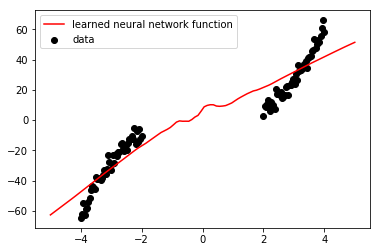

In [3]:
nn = Feedforward(nlm_architecture, random=random_seed)

t0 = time.time()
nn.fit(x_train, y_train, opt_params)
nn_time = np.round(time.time() - t0, 3)

mse = nn.objective_trace.min()

print(f"\n {nn_time} Seconds, Log Likilihood {mse}")

#predict on the test x-values
y_test_pred = nn.forward(nn.weights, x_test)

#visualize the function learned by the neural network
plt.scatter(x_train.flatten(), y_train.flatten(), color='black', label='data')
plt.plot(x_test.flatten(), y_test_pred.flatten(), color='red', label='learned neural network function')
plt.legend(loc='best')
plt.show()


### NLM Demo

In [4]:
# test
test_nlm = NLM(prior_variance,
               y_noise_variance,
               regularization_param_nlm, 
               nlm_architecture, 
               random_state = random_seed)

In [5]:

t0 = time.time()
test_nlm.train(x_train,y_train, opt_params)
nlm_time = np.round(time.time() - t0, 3)
nlm_mse = test_nlm.ff.objective_trace.min()

print(f"{nlm_time} Seconds, {nlm_mse} MSE")

 Iteration 0 lower bound 5329.818532998265; gradient mag: 13246.928836978932
Done Training
0.709 Seconds, 582.2489980099894 MSE


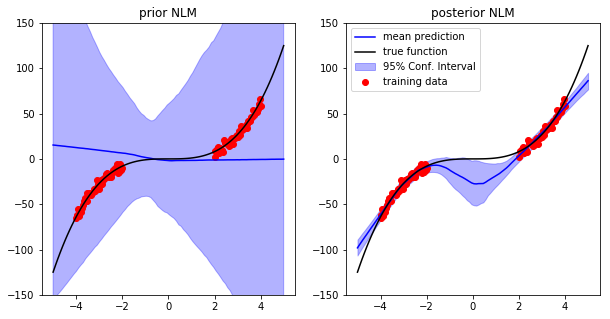

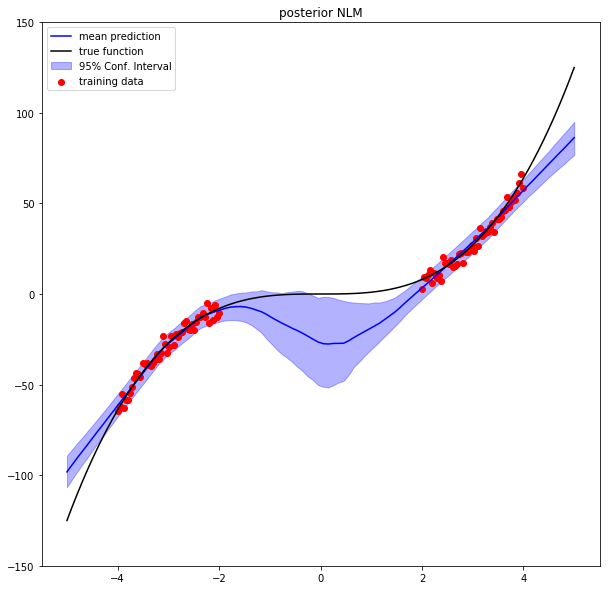

In [6]:
## MULTI FIG
fig,ax = plt.subplots(2,2 ,figsize=(10,5))
i = 0
for predictive_name, boolean in {"prior NLM":True, "posterior NLM":False}.items():
    predictives, predictive_samples = test_nlm.predict(x_test,prior = boolean)
    bh.viz_pp_samples(x_train, y_train,x_test.flatten(),predictive_samples,predictive_name, ax[i])
    i +=1
plt.legend()
fig.savefig("figs/test2")


## SINGLE FIG
single_plot = bh.viz_pp_samples(x_train, y_train,x_test.flatten(),predictive_samples,predictive_name)
single_plot.savefig("figs/test")


In [7]:
from autograd import scipy as sp
import math
        
test_nlm.get_log_l(x_train,y_train,x_valid,y_valid)

-128.24616986880207

## testing log likilihood

In [ ]:
# we should VERIFY that log likelihood at 5000 is greater than 1000
i_params = opt_params.copy()
for i in [10,100,200,300,400,1000]:
    i_params['max_iteration'] = i
    test_nlm.train(x_train,y_train, i_params)
    print(test_nlm.get_log_l(x_train,y_train,x_valid,y_valid))

In [ ]:
# looks good
print(opt_params['max_iteration'])
i_architecture = architecture.copy()
for i in [1,2,5,10,50]:
    print(f"\n width: {i}")
    i_architecture['width'] = i
    test_nlm_i = NLM(prior_var,y_var, regularization_param_nlm,i_architecture, random_state = np.random.RandomState(0))
    test_nlm_i.train(x_train,y_train, opt_params)
    print(test_nlm_i.get_log_l(x_train,y_train,x_valid,y_valid))